- Use the `torch.arange` function to create a list of numbers starting from 0 to 1000 with a step of 2
- Use the `unsqueeze` method to add 1 dimension so you will get a tensor of shape (500,1)

In [28]:
import torch


weight = 4
bias = 10

X = torch.arange(0, 1000, 2, dtype=torch.float).unsqueeze(1)
y = weight * X + bias

# A `torch.tensor` is a multi-dimensional array that serves as the primary data structure for the PyTorch deep learning library. It is similar to a NumPy array but includes specialized features, such as GPU acceleration and automatic differentiation, which are essential for training neural networks.
X[:5], y[:5]

(tensor([[0.],
         [2.],
         [4.],
         [6.],
         [8.]]),
 tensor([[10.],
         [18.],
         [26.],
         [34.],
         [42.]]))

## Building a Neural Network Model

In PyTorch, we create models by defining a class that inherits from `nn.Module`. Here's what each part does:

### Key Components:

1. **`nn.Module`**: The base class for all neural network models in PyTorch. It provides essential functionality like tracking parameters and switching between training/evaluation modes.

2. **`__init__` method**: This is where we define the model's **learnable parameters** (weights and biases). These are the values that will be adjusted during training.

3. **`nn.Parameter`**: Wraps a tensor and tells PyTorch *"this is a learnable weight - please track gradients for it!"*

4. **`requires_grad=True`**: Enables automatic differentiation. PyTorch will record all operations on this tensor so it can calculate gradients during backpropagation.

5. **`forward` method**: Defines the **computation** that happens when data passes through the model. For linear regression, this is simply: $y = x \cdot a + b$

6. **`torch.randn(1)`**: Initializes parameters with random values from a normal distribution. The model will learn the correct values during training.

### Our Model:
We're building a simple **linear regression** model with:
- `a` = the slope (weight)
- `b` = the y-intercept (bias)

In [3]:
import torch.nn as nn


class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        # When a tensor has requires_grad=True, PyTorch begins recording a history of every operation performed on it
        self.a = nn.Parameter(torch.randn(1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        return x * self.a + self.b
    

model = LinearRegressionModel()
print(model.state_dict())

OrderedDict({'a': tensor([-0.9049]), 'b': tensor([-0.8598])})


In [4]:
idx = int(len(X) * 0.8)
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

# (Batch_Size, Number_of_Features).
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([400, 1]),
 torch.Size([100, 1]),
 torch.Size([400, 1]),
 torch.Size([100, 1]))

A loss function, also known as a criterion, cost function or error function, is a mathematical function used in machine learning and statistical modelling to quantify the difference between the predicted values produced by a model and the actual values from the data. The primary purpose of a loss function is to **provide a measure of how well the model is performing**.


Optimizers are **algorithms** or methods used **to adjust the parameters of a neural network** to minimize the loss function during training. They play a crucial role in the training process by determining how the model's weights are updated based on the computed gradients. 

In [ ]:
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss # L1 Loss (Mean Absolute Error)

criterion = L1Loss()
optimizer = Adam(model.parameters())

## The Training Loop

The training loop is the heart of any machine learning model. It's where the model actually **learns** from data. Here's what happens in each iteration:

### Key Concepts:

1. **Epoch**: One complete pass through the entire training dataset. We typically train for many epochs.

2. **Mini-batch**: Instead of processing all data at once, we split it into smaller chunks (batches of 16 samples here). This makes training more memory-efficient and can help the model generalize better.

3. **Training vs Evaluation Mode**: 
   - `model.train()` - Enables training-specific behaviors (like dropout)
   - `model.eval()` - Disables these behaviors for testing

4. **The 5 Steps of Training** (per batch):
   - **Forward Pass**: Feed data through the model to get predictions
   - **Calculate Loss**: Measure how wrong our predictions are
   - **Zero Gradients**: Clear old gradient information
   - **Backward Pass**: Calculate how to adjust weights to reduce error
   - **Optimizer Step**: Actually update the weights

In [23]:
for epoch in range(100):
    # Track total loss for this epoch (for monitoring progress)
    running_train_loss = 0
    running_test_loss = 0

    # ========== TRAINING PHASE ==========
    # Set model to training mode
    model.train()
    
    # Loop through training data in mini-batches of 16
    for idx in range(0, len(X_train), 16):
        # Get a batch of 16 samples
        X = X_train[idx : idx+16]
        y = y_train[idx : idx+16]

        # STEP 1: Forward Pass - Get predictions from the model
        y_preds = model(X)

        # STEP 2: Calculate Loss - How wrong are our predictions?
        loss = criterion(y_preds, y)

        # STEP 3: Zero Gradients - Clear old gradients (otherwise they accumulate!)
        optimizer.zero_grad()

        # STEP 4: Backward Pass - Calculate gradients (how to adjust each weight)
        loss.backward()

        # STEP 5: Optimizer Step - Update weights using the gradients
        optimizer.step()

        # Accumulate loss for logging
        running_train_loss += loss.item()
    
    # ========== EVALUATION PHASE ==========
    # Set model to evaluation mode (disables training-specific behaviors)
    model.eval()
    
    # Loop through test data in mini-batches
    for idx in range(0, len(X_test), 16):
        X = X_test[idx : idx+16]
        y = y_test[idx : idx+16]

        # torch.inference_mode() disables gradient tracking (faster, uses less memory)
        with torch.inference_mode():
            y_preds = model(X)

        loss = criterion(y_preds, y)
        running_test_loss += loss.item()
    
    # Calculate average loss per batch
    trl = running_train_loss / (len(X_train) / 16)
    tel = running_test_loss / (len(X_test) / 16)
    
    # Print progress - watch the loss decrease as the model learns!
    print(f"Epoch: {epoch} train loss: {trl}, test loss: {tel}")

Epoch: 0 train loss: 0.09447648525238037, test loss: 0.49115234375
Epoch: 1 train loss: 0.10374999046325684, test loss: 0.49296875
Epoch: 2 train loss: 0.10324609518051148, test loss: 0.4724560546875
Epoch: 3 train loss: 0.10146270036697387, test loss: 0.48694091796875
Epoch: 4 train loss: 0.1410353112220764, test loss: 0.39963134765625
Epoch: 5 train loss: 0.05301755428314209, test loss: 0.30240234375
Epoch: 6 train loss: 0.19799753427505493, test loss: 0.3698388671875
Epoch: 7 train loss: 0.32427040338516233, test loss: 0.0027783203125
Epoch: 8 train loss: 0.07095016002655029, test loss: 0.2686767578125
Epoch: 9 train loss: 0.09668065071105957, test loss: 0.12601806640625
Epoch: 10 train loss: 0.1060814356803894, test loss: 0.27400634765625
Epoch: 11 train loss: 0.23427531480789185, test loss: 0.19780029296875
Epoch: 12 train loss: 0.20372942924499512, test loss: 0.24061279296875
Epoch: 13 train loss: 0.09080961704254151, test loss: 0.43447265625
Epoch: 14 train loss: 0.0241450715065

## Understanding Backpropagation (How the Model Learns)

The magic happens in `loss.backward()`. Here's a simplified explanation:

### 1. The Computational Graph
When you perform operations on tensors with `requires_grad=True`, PyTorch secretly builds a **graph** that records every operation. Think of it like keeping a detailed recipe of everything you did.

### 2. Chaining Operations
Each operation creates a link back to the previous one. For example:
```
input → multiply by weight → add bias → calculate loss
```
This creates a chain of connected steps.

### 3. The Backward Pass (Backpropagation)
When you call `.backward()` on the loss:
- PyTorch walks **backwards** through the chain
- It uses the **Chain Rule** from calculus to figure out: *"How much did each weight contribute to the final error?"*
- These contributions are called **gradients**

### 4. The Optimizer Step
The optimizer then uses these gradients to:
- Nudge weights in the **opposite direction** of the error
- Weights that caused more error get adjusted more
- This is **Gradient Descent** - we're descending down the "hill" of error!

### Why Zero Gradients?
PyTorch **accumulates** gradients by default (adds new ones to old ones). We call `optimizer.zero_grad()` to clear old gradients before each batch, so we only use the current batch's information.

## Visualizing the Results

Now let's see how well our model learned! We'll plot:
- **Red line**: The actual (true) values
- **Blue line**: Our model's predictions

If training worked well, the blue line should closely follow the red line.

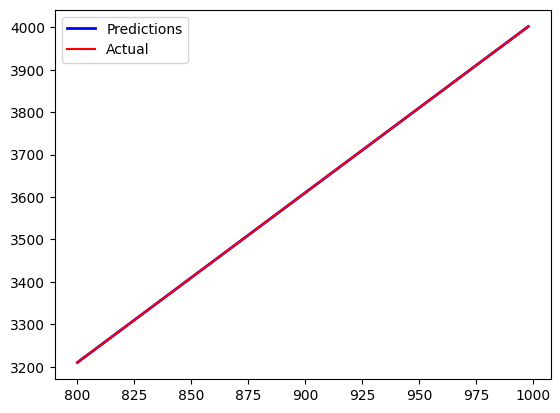

In [24]:
import matplotlib.pyplot as plt

model.eval()
with torch.inference_mode():
    y_preds = model(X_test)

fig, ax = plt.subplots()
ax.plot(X_test, y_preds, color="blue", linewidth=2, label="Predictions")
ax.plot(X_test, y_test, color="red", label="Actual")
ax.legend()
plt.show()


## Checking the Learned Parameters

Let's look at what values the model learned for `a` (weight) and `b` (bias).

Remember, our original data was generated with:
- **weight = 4**
- **bias = 10**

If training worked correctly, the model's parameters should be very close to these values!

In [25]:
model.state_dict()

OrderedDict([('a', tensor([3.9999])), ('b', tensor([9.9985]))])